In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # eg: doseage of a drug for Alzheimers disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 


In [3]:
y = -0.5 * x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)
y

tensor([ 1.8198,  1.5740,  0.8418,  0.6250,  0.1473, -0.5106, -1.4874, -1.6278])

For reproducibility of this demo, here's a fixed example of  𝑦  values obtained by running the commented-out line above:

In [4]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

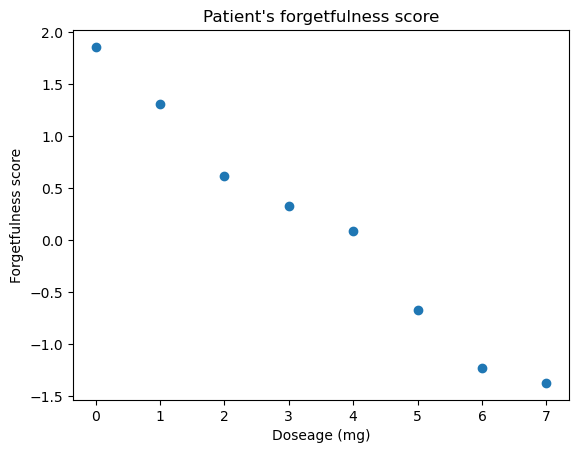

In [5]:
fig, ax = plt.subplots()
plt.title("Patient's forgetfulness score")
plt.xlabel("Doseage (mg)")
plt.ylabel("Forgetfulness score")
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9... (near zero value)


(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [6]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

... and do the same to the $y$-intercept parameter $b$:

In [7]:
# random near zero value for b selected here is 0.1
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [10]:
def regression_plot(my_x, my_y, my_m, my_b):
    my_m = my_m.detach().numpy()
    my_b = my_b.detach().numpy()
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_m * x_min + my_b, my_m * x_max + my_b

    ax.set_xlim([x_min, x_max])

    _ = ax.plot([x_min, x_max], [y_min, y_max])

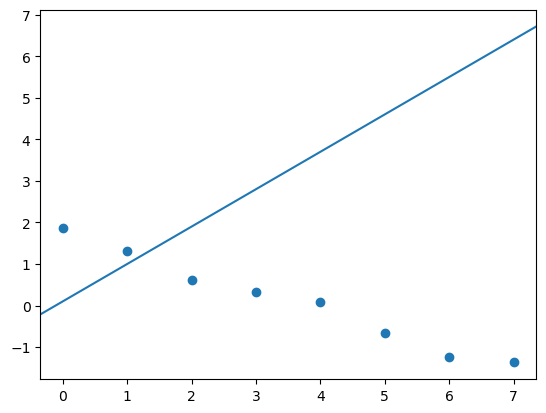

In [11]:
regression_plot(x, y, m, b)

In [12]:
def regression(my_x, my_m, my_b):
    return my_m * my_x + my_b

### Machine Learning

in 4 easy steps:

**STEP 1:** Forward Pass

In [13]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**STEP 2:** Compare $\hat{y}$ with true $y$ to calculate cost (loss) C

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. (Mean Squared error cost) MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [15]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y) ** 2)
    return sigma/len(my_y)

In [16]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**STEP 3:** Use autodiff to calculate gradient of $C$ w.r.t parameters

In [17]:
C.backward()

In [18]:
m.grad

tensor([36.3050])

In [19]:
b.grad

tensor([6.2650])

**STEP 4:** Gradient Descent

In [20]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [21]:
optimizer.step()

Confirm parameters have been adjusted senseibly:

In [22]:
m

tensor([0.5369], requires_grad=True)

In [23]:
b

tensor([0.0374], requires_grad=True)

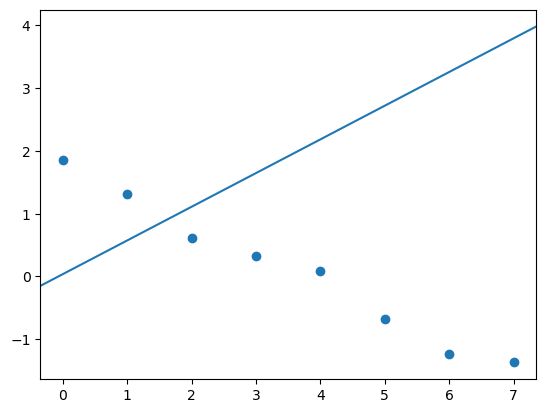

In [24]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has reduced

In [25]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost towards zero:

In [ ]:
epochs = 1000
for epoch in range(epochs):

    optimizer.zero_grad() #reset gradients to zero; else they will accumulate

    yhat = regression(x, m, b) # step 1: make predictions
    C = mse(yhat, y) # step 2: compute cost (forward pass)
    C.backward() # step 3: compute gradients - autodiff (backword pass)
    optimizer.step() # step 4: update parameters

    print(f"Epoch {epoch:.3g}, Cost = {C.item():.3g}, m grad = {m.grad.item():.3g}, b grad = {b.grad.item():.3g}")

Epoch 0, Cost = 4.08, m grad = 14.8, b grad = 1.91
Epoch 1, Cost = 2.25, m grad = 9.49, b grad = 0.831
Epoch 2, Cost = 1.51, m grad = 6.11, b grad = 0.15
Epoch 3, Cost = 1.2, m grad = 3.96, b grad = -0.28
Epoch 4, Cost = 1.07, m grad = 2.59, b grad = -0.552
Epoch 5, Cost = 1.01, m grad = 1.72, b grad = -0.723
Epoch 6, Cost = 0.981, m grad = 1.17, b grad = -0.829
Epoch 7, Cost = 0.962, m grad = 0.82, b grad = -0.894
Epoch 8, Cost = 0.948, m grad = 0.595, b grad = -0.934
Epoch 9, Cost = 0.936, m grad = 0.452, b grad = -0.957
Epoch 10, Cost = 0.925, m grad = 0.361, b grad = -0.969
Epoch 11, Cost = 0.915, m grad = 0.302, b grad = -0.975
Epoch 12, Cost = 0.904, m grad = 0.265, b grad = -0.977
Epoch 13, Cost = 0.894, m grad = 0.241, b grad = -0.976
Epoch 14, Cost = 0.884, m grad = 0.225, b grad = -0.973
Epoch 15, Cost = 0.874, m grad = 0.214, b grad = -0.969
Epoch 16, Cost = 0.864, m grad = 0.207, b grad = -0.965
Epoch 17, Cost = 0.854, m grad = 0.202, b grad = -0.96
Epoch 18, Cost = 0.845, 

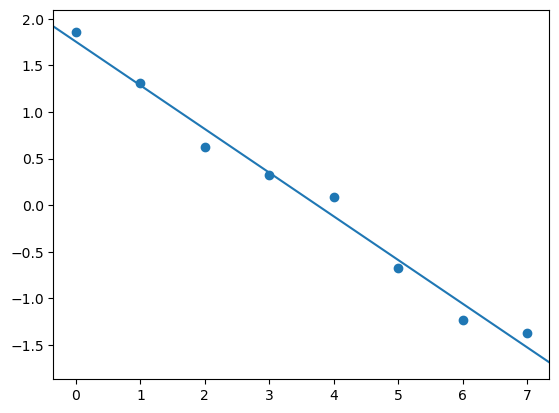

In [28]:
regression_plot(x, y, m, b)

In [29]:
m.item()

-0.46813252568244934

In [30]:
b.item()

1.7543290853500366

**N.B.**: The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be. 